In [ ]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.8 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima

In [ ]:
def adf_test(df):
    test = adfuller(df)
    print('adf: ', test[0])
    print('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0] > test[4]['5%']:
        print('Ряд не стационарен')
    else:
        print('Ряд стационарен')

#MSE & R2
def mseAndR2(y_actual, y_smoothed):
    n = len(y_actual)
    mse = ((y_actual - y_smoothed)**2).mean()
    y_mean = y_actual.mean()
    ss_total = ((y_actual - y_mean)**2).sum()
    ss_residual = ((y_actual - y_smoothed)**2).sum()
    r_squared = 1 - (ss_residual / ss_total)

    return mse, r_squared

#AKF
def akf(series, lag):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(series, lags=lag, ax=ax1)
    plot_pacf(series, lags=lag, ax=ax2)
    plt.show()

#Components plot
def plot_сomponents(dataframe, seasonal_period):
    result = seasonal_decompose(dataframe, model='additive', period=seasonal_period)
    plt.figure(figsize=(12, 7))
    plt.subplot(411)
    plt.plot(result.observed, label='Доходность')
    plt.legend()
    plt.subplot(412)
    plt.plot(result.trend, label='Тренд')
    plt.legend()
    plt.subplot(413)
    plt.plot(result.seasonal, label='Сезонность')
    plt.legend()
    plt.subplot(414)
    plt.plot(result.resid, label='Остатки', marker='o')
    plt.legend()
    plt.show()

def metrics(real, forecast):

    if type(real)==pd.core.frame.DataFrame:
        real=real[real.columns[0]].values
    #real=np.array(real[real.columns[0]].values)
    forecast=np.array(forecast)
    print('MAD:', round(abs(real-forecast).mean(),4))
    print('MSE:', round(((real-forecast)**2).mean(),4))
    print('MAPE:', round((abs(real-forecast)/real).mean(),4))
    print('MPE:', round(((real-forecast)/real).mean(),4))
    print('Стандартная ошибка:', round(((real-forecast)**2).mean()**0.5,4))

In [ ]:
btc_df = pd.read_csv('btc.csv', index_col=['date'], parse_dates=['date']).drop(labels=['difficulty','hash-rate', 'market-price', 'trade-volume'], axis=1)
revenue = btc_df['2023-01-01':'2023-12-31']
revenue.head()

,miners-revenue
0,0.000000
1,0.007869
2,0.024639
3,0.053419
4,0.036743


In [ ]:
revenue = revenue * 0.0000001
revenue = revenue
revenue.describe()

,miners-revenue
count,1.520000e+02
mean,4.492569e-08
std,2.175957e-08
min,0.000000e+00
25%,3.006108e-08
50%,4.779327e-08
75%,6.030962e-08
max,1.000000e-07


In [ ]:
revenue.resample(rule='W').mean().diff().plot(figsize=(12,5))

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

In [ ]:
adf_test(revenue)

adf:  -1.7065262228803741
p-value:  0.4277531462876803
Critical values:  {'1%': -3.479007355368944, '5%': -2.8828782366015093, '10%': -2.5781488587564603}
Ряд не стационарен


In [ ]:
adf_test(revenue.diff().dropna()) # дифференцированрие первого порядка

adf:  -5.147069827701383
p-value:  1.1264839532626463e-05
Critical values:  {'1%': -3.479007355368944, '5%': -2.8828782366015093, '10%': -2.5781488587564603}
Ряд стационарен


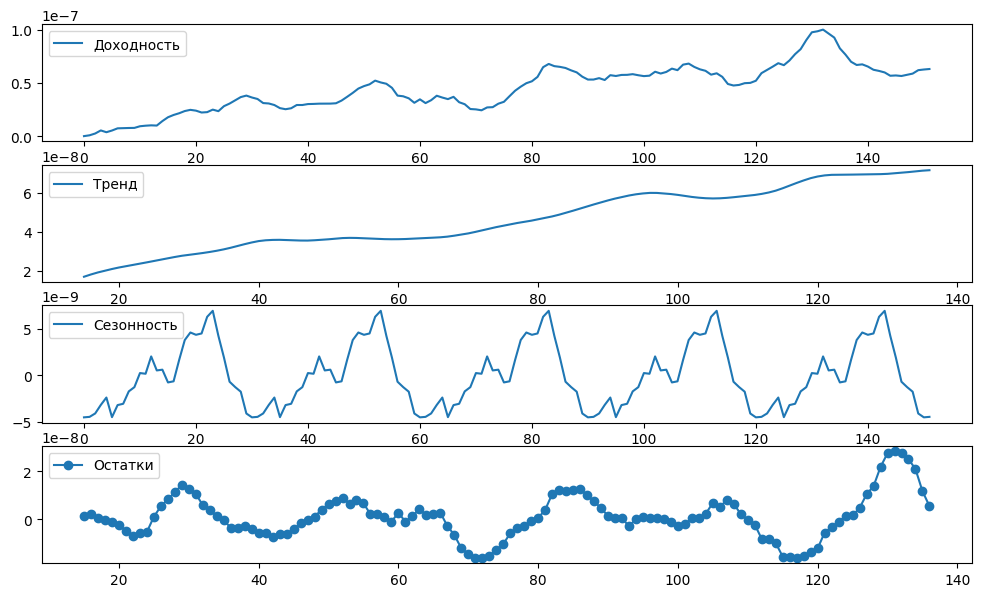

In [ ]:
plot_сomponents(revenue, 30)

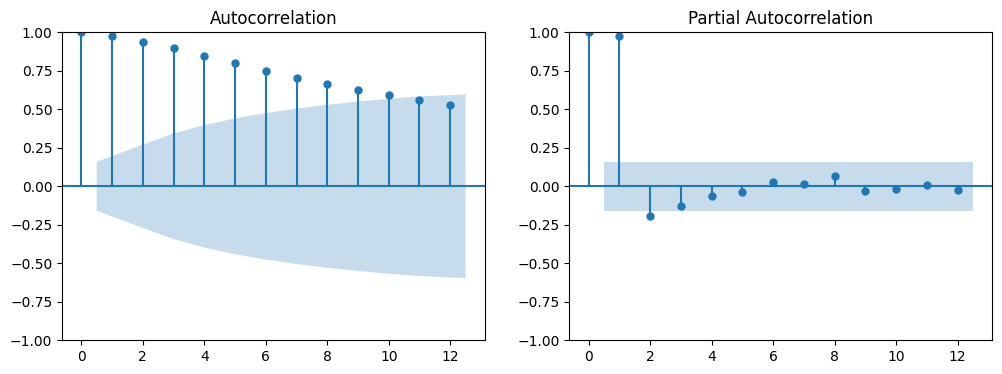

In [ ]:
akf(revenue, 12)

In [ ]:
data_to_forecast = revenue#.resample(rule='W').mean()

In [ ]:
find_optimal_model = auto_arima(data_to_forecast, seasonal=True, m=6)
print(find_optimal_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  152
Model:               SARIMAX(0, 1, 0)   Log Likelihood                1873.628
Date:                Sat, 20 Apr 2024   AIC                          -3745.257
Time:                        19:24:11   BIC                          -3742.239
Sample:                             0   HQIC                         -3744.031
                                - 152                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.251e-12   1.55e-10      0.015      0.988   -3.02e-10    3.06e-10
Ljung-Box (L1) (Q):                  38.26   Jarque-Bera (JB):                 4.06
Prob(Q):                              0.00   Pr

In [ ]:
arima_model = ARIMA(data_to_forecast, order=(2,1,10), seasonal_order=(2,0,0,6))
arima_fit = arima_model.fit()
forecast = arima_fit.forecast(steps=20)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


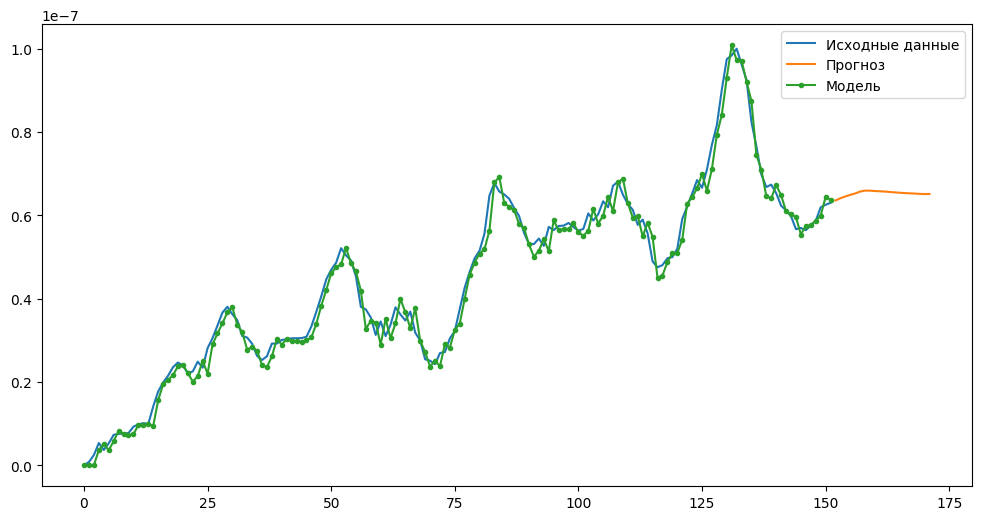

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(data_to_forecast, label='Исходные данные')
plt.plot(forecast, label='Прогноз')
plt.plot(arima_fit.fittedvalues, label='Модель', marker='.')
plt.legend()
plt.show()

In [ ]:
forecast.describe()

count    6.500000e+01
mean     6.228377e-08
std      2.225062e-09
min      6.001138e-08
25%      6.098755e-08
50%      6.140808e-08
75%      6.248052e-08
max      6.873272e-08
Name: predicted_mean, dtype: float64

In [ ]:
metrics(data_to_forecast[300:], forecast)

MAD: 0.0
MSE: 0.0
MAPE: inf
MPE: -inf
Стандартная ошибка: 0.0


<ipython-input-3-8956cdf7e97f>:55: RuntimeWarning: divide by zero encountered in divide
  print('MAPE:', round((abs(real-forecast)/real).mean(),4))
<ipython-input-3-8956cdf7e97f>:56: RuntimeWarning: divide by zero encountered in divide
  print('MPE:', round(((real-forecast)/real).mean(),4))


Коэф Сортино

In [ ]:
def minmax(series, new_min=-1, new_max=1):
    min_val = series.min()
    max_val = series.max()
    normalized_series = new_min + ((series - min_val) * (new_max - new_min)) / (max_val - min_val)
    return normalized_series

def sortino_ratio(returns, risk_free_rate=0, target=0):
    downside_returns = returns - target
    downside_returns = downside_returns[downside_returns < 0]
    expected_return = returns.mean()
    downside_deviation = np.sqrt((expected_return ** 2)).mean()
    sortino_ratio = (expected_return - risk_free_rate) / downside_deviation
    print(sortino_ratio)

In [ ]:
import json

with open('coins.json', 'r') as file:
    data = json.load(file)

coins_data = []

for coin, details in data['coins'].items():
    coin_name = coin
    coin_revenue = details.get('btc_revenue', None)
    coins_data.append({'coin': coin_name, 'revenue': coin_revenue})

df_coins = pd.DataFrame(coins_data)
df_coins[:6].sort_values(by='revenue', ascending=False)

,coin,revenue
2,Nicehash-KawPow,0.00003396
0,Ravencoin,0.00003324
3,Nirmata,0.0000327
4,Hoosat,0.00003158
1,Zano,0.00003104
5,Aittcoin,0.00002983


In [ ]:
coin_list = []
for index, row in df_coins.iterrows():
    coin_name = row['coin']
    coin_revenue = row['revenue']
    ratio = sortino_ratio(coin_revenue)
    coin_list.append({'coin': coin_name, 'sortino': ratio})

In [ ]:
print(coin_list.sort_values(by='revenue', ascending=False))

                   coin     revenue
9               Vultaic  0.00005005
2       Nicehash-KawPow  0.00003396
0             Ravencoin  0.00003324
3               Nirmata   0.0000327
4                Hoosat  0.00003158
..                  ...         ...
27    Nicehash-IronFish  0.00000382
65                 Etho  0.00000361
66        HavenProtocol  0.00000267
67  Nicehash-Cuckatoo32  0.00000031
68               Cortex         0.0

[69 rows x 2 columns]
